Optimized delta [rad/s]: -5.5428999844740224e-08
Optimized delta [Hz]: -8.821799315930306e-09
Optimized actual pi time [µs]: 40.00002241388943
Optimized Rabi frequency Ω [rad/s]: 78539.7723302005
Optimized Rabi frequency Ω/2π [Hz]: 12499.992995663477
Correction factor pi_actual / pi_used: 1.0000005603472357


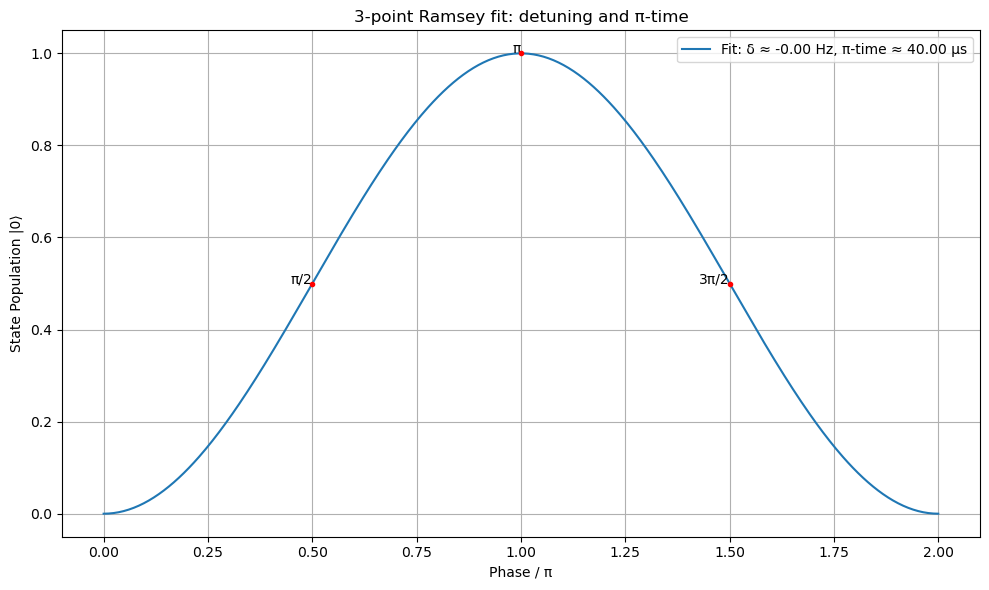

In [2]:
import numpy as np
from scipy.linalg import expm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def unitary_product_with_ket_zero(pi_time_used, pi_time_actual, T, delta, t_wait_T):
    omega = np.pi / (pi_time_actual * 1e-6)
    t_pi_over_2_used = (pi_time_used * 1e-6) / 2

    def U1(omega, t):
        H = np.array([[0, omega / 2],
                      [omega / 2, delta]], dtype=complex)
        return expm(-1j * H * t)

    def U_wait(t):
        H = np.array([[0, 0],
                      [0, delta]], dtype=complex)
        return expm(-1j * H * t)

    def U2(omega, t, t_wait_T):
        phase = np.exp(-1j * np.pi * t_wait_T)
        H = np.array([[0, omega * phase / 2],
                      [omega * np.conj(phase) / 2, delta]], dtype=complex)
        return expm(-1j * H * t)

    U1_ = U1(omega, t_pi_over_2_used)
    U_wait_ = U_wait(T)
    U2_ = U2(omega, t_pi_over_2_used, t_wait_T)

    product = U2_ @ U_wait_ @ U1_
    ket_zero = np.array([1, 0], dtype=complex)
    result = product @ ket_zero
    state_pop = np.abs(result) ** 2
    return state_pop[0].real

def call_unitary_product_three(pi_time_used, pi_time_actual, T, delta):
    r1 = unitary_product_with_ket_zero(pi_time_used, pi_time_actual, T, delta, 0.5)
    r2 = unitary_product_with_ket_zero(pi_time_used, pi_time_actual, T, delta, 1.0)
    r3 = unitary_product_with_ket_zero(pi_time_used, pi_time_actual, T, delta, 1.5)
    return r1, r2, r3

def fitting_function(params, pi_time_used, T, target_results):
    delta, pi_time_actual = params
    c1, c2, c3 = call_unitary_product_three(pi_time_used, pi_time_actual, T, delta)
    t1, t2, t3 = target_results
    error = (c1 - t1) ** 2 + (c2 - t2) ** 2 + (c3 - t3) ** 2
    return error

pi_time_used = 40
T = 100e-6

initial_delta_guess = 100 * 2 * np.pi
initial_pi_time_actual_guess = 40.0

result_pi_over_2 = 0.5
result_pi = 1
result_3pi_over_2 = 0.5
target_results = (result_pi_over_2, result_pi, result_3pi_over_2)

initial_params = np.array([initial_delta_guess, initial_pi_time_actual_guess])

result = minimize(
    fitting_function,
    initial_params,
    args=(pi_time_used, T, target_results),
    method="Nelder-Mead"
)

optimized_delta, optimized_pi_time_actual = result.x

print("Optimized delta [rad/s]:", optimized_delta)
print("Optimized delta [Hz]:", optimized_delta / (2 * np.pi))
print("Optimized actual pi time [µs]:", optimized_pi_time_actual)
print("Optimized Rabi frequency Ω [rad/s]:", np.pi / (optimized_pi_time_actual * 1e-6))
print("Optimized Rabi frequency Ω/2π [Hz]:", np.pi / (optimized_pi_time_actual * 1e-6) / (2 * np.pi))
print("Correction factor pi_actual / pi_used:", optimized_pi_time_actual / pi_time_used)

t_wait_T_values = np.linspace(0, 2, 500)
state_populations = [
    unitary_product_with_ket_zero(pi_time_used, optimized_pi_time_actual, T, optimized_delta, x)
    for x in t_wait_T_values
]

plt.figure(figsize=(10, 6))
plt.plot(
    t_wait_T_values,
    state_populations,
    label=f"Fit: δ ≈ {optimized_delta / (2 * np.pi):.2f} Hz, π-time ≈ {optimized_pi_time_actual:.2f} µs"
)

plt.scatter(
    [0.5, 1.0, 1.5],
    target_results,
    color="red",
    zorder=5,
    marker="."
)

plt.text(0.5, target_results[0], "π/2", fontsize=10, ha="right")
plt.text(1.0, target_results[1], "π", fontsize=10, ha="right")
plt.text(1.5, target_results[2], "3π/2", fontsize=10, ha="right")

plt.xlabel("Phase / π")
plt.ylabel("State Population |0⟩")
plt.title("3-point Ramsey fit: detuning and π-time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("three_point_ramsey_calibration.png", dpi=300)
plt.show()


delta [rad/s]: 0
delta / 2π [Hz]: 0.0
pi_time_used [µs]: 50.0
pi_time_actual [µs]: 40.0
populations: [np.float64(0.14644660940672613), np.float64(0.573223304703363), np.float64(1.0), np.float64(0.573223304703363), np.float64(0.14644660940672613)]
result_pi_over_2 =  0.573223304703363
result_pi =  1.0
result_3pi_over_2 =  0.573223304703363


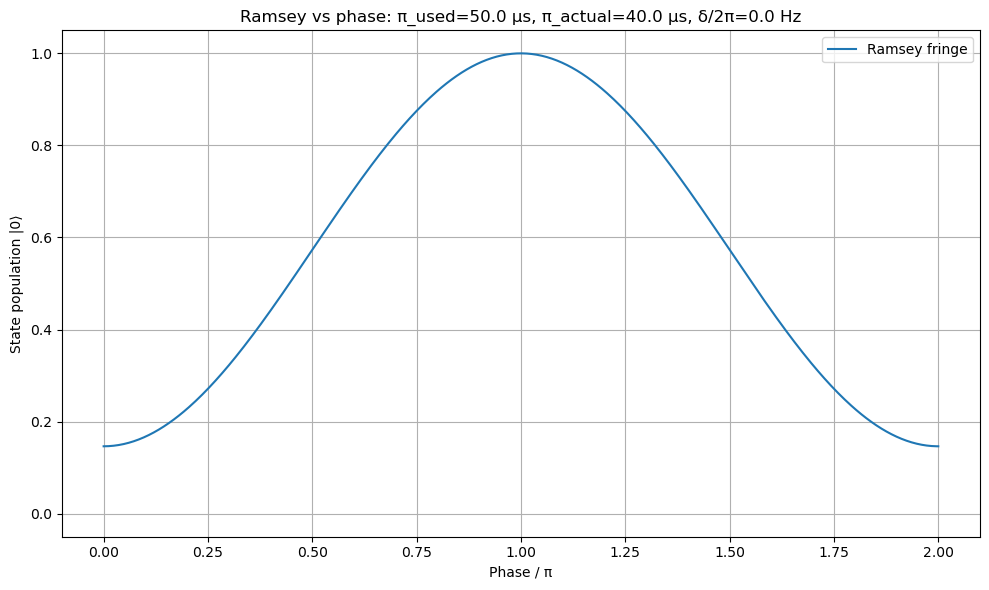

In [17]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

def unitary_product_with_ket_zero(pi_time_used, pi_time_actual, T, delta, phase_over_pi):
    omega = np.pi / (pi_time_actual * 1e-6)
    t_pi_over_2 = (pi_time_used * 1e-6) / 2
    phase = np.pi * phase_over_pi

    def U1(omega, t):
        H = np.array([[0, omega / 2],
                      [omega / 2, delta]], dtype=complex)
        return expm(-1j * H * t)

    def U_wait(t):
        H = np.array([[0, 0],
                      [0, delta]], dtype=complex)
        return expm(-1j * H * t)

    def U2(omega, t, phase):
        H = np.array([[0, omega * np.exp(1j * (phase )) / 2],
                      [omega * np.exp(-1j * (phase )) / 2, delta]], dtype=complex)
        return expm(-1j * H * t)

    U1_ = U1(omega, t_pi_over_2)
    U_wait_ = U_wait(T)
    U2_ = U2(omega, t_pi_over_2, phase)

    product = U2_ @ U_wait_ @ U1_
    ket_zero = np.array([1, 0], dtype=complex)
    result = product @ ket_zero
    state_pop = np.abs(result) ** 2
    return state_pop[0].real

def call_unitary_product_twice(pi_time_used, pi_time_actual, T, delta):
    r0 = unitary_product_with_ket_zero(pi_time_used, pi_time_actual, T, delta, 0)
    r05 = unitary_product_with_ket_zero(pi_time_used, pi_time_actual, T, delta, 0.5)
    r1 = unitary_product_with_ket_zero(pi_time_used, pi_time_actual, T, delta, 1)
    r32 = unitary_product_with_ket_zero(pi_time_used, pi_time_actual, T, delta, 1.5)
    r2 = unitary_product_with_ket_zero(pi_time_used, pi_time_actual, T, delta, 2)
    return r0, r05, r1, r32, r2

pi_time_used = 50.0
pi_time_actual = 40.0
T = 100e-6
delta = 0

print("delta [rad/s]:", delta)
print("delta / 2π [Hz]:", delta / (2 * np.pi))
print("pi_time_used [µs]:", pi_time_used)
print("pi_time_actual [µs]:", pi_time_actual)

r0, r05, r1, r32, r2 = call_unitary_product_twice(pi_time_used, pi_time_actual, T, delta)
print('populations:', [r0, r05, r1, r32, r2])

print('result_pi_over_2 = ', float(r05))
print('result_pi = ', float(r1))
print('result_3pi_over_2 = ', float(r32))

# print("State population at phase = π/2 (phase_over_pi=0.5):", result1)
# print("State population at phase = 3π/2 (phase_over_pi=1.5):", result2)

phase_over_pi_values = np.linspace(0.0, 2.0, 500)
state_populations = [
    unitary_product_with_ket_zero(pi_time_used, pi_time_actual, T, delta, x)
    for x in phase_over_pi_values
]

plt.figure(figsize=(10, 6))
plt.plot(phase_over_pi_values, state_populations, label="Ramsey fringe")

plt.xlabel("Phase / π")
plt.ylabel("State population |0⟩")
plt.title(
    f"Ramsey vs phase: π_used={pi_time_used:.1f} µs, "
    f"π_actual={pi_time_actual:.1f} µs, δ/2π={delta/(2*np.pi):.1f} Hz"
)
plt.grid(True)
plt.ylim(-0.05,1.05)
plt.legend()
plt.tight_layout()
plt.show()


Optimized delta [rad/s]: -1.3142905418373475e-05
Optimized delta [Hz]: -2.0917583639233933e-06
Optimized actual pi time [µs]: 66.66666711431792
Optimized Rabi frequency Ω [rad/s]: 47123.88948742088
Optimized Rabi frequency Ω/2π [Hz]: 7499.999949639235
Correction factor pi_actual / pi_used: 1.3333333422863582


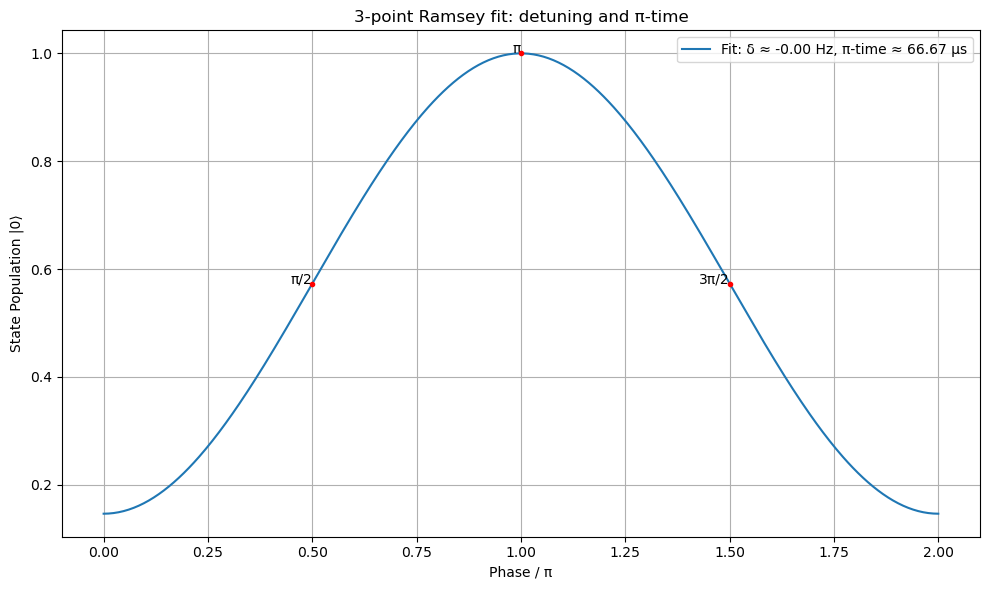

In [20]:
import numpy as np
from scipy.linalg import expm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def unitary_product_with_ket_zero(pi_time_used, pi_time_actual, T, delta, t_wait_T):
    omega = np.pi / (pi_time_actual * 1e-6)
    t_pi_over_2_used = (pi_time_used * 1e-6) / 2

    def U1(omega, t):
        H = np.array([[0, omega / 2],
                      [omega / 2, delta]], dtype=complex)
        return expm(-1j * H * t)

    def U_wait(t):
        H = np.array([[0, 0],
                      [0, delta]], dtype=complex)
        return expm(-1j * H * t)

    def U2(omega, t, t_wait_T):
        phase = np.exp(-1j * np.pi * t_wait_T)
        H = np.array([[0, omega * phase / 2],
                      [omega * np.conj(phase) / 2, delta]], dtype=complex)
        return expm(-1j * H * t)

    U1_ = U1(omega, t_pi_over_2_used)
    U_wait_ = U_wait(T)
    U2_ = U2(omega, t_pi_over_2_used, t_wait_T)

    product = U2_ @ U_wait_ @ U1_
    ket_zero = np.array([1, 0], dtype=complex)
    result = product @ ket_zero
    state_pop = np.abs(result) ** 2
    return state_pop[0].real

def call_unitary_product_three(pi_time_used, pi_time_actual, T, delta):
    r1 = unitary_product_with_ket_zero(pi_time_used, pi_time_actual, T, delta, 0.5)
    r2 = unitary_product_with_ket_zero(pi_time_used, pi_time_actual, T, delta, 1.0)
    r3 = unitary_product_with_ket_zero(pi_time_used, pi_time_actual, T, delta, 1.5)
    return r1, r2, r3

def fitting_function(params, pi_time_used, T, target_results):
    delta, pi_time_actual = params
    c1, c2, c3 = call_unitary_product_three(pi_time_used, pi_time_actual, T, delta)
    t1, t2, t3 = target_results
    error = (c1 - t1) ** 2 + (c2 - t2) ** 2 + (c3 - t3) ** 2
    return error

pi_time_used = 50.0
T = 100e-6

initial_delta_guess = 100 * 2 * np.pi

result_pi_over_2 =  0.573223304703363
result_pi =  1.0
result_3pi_over_2 =  0.573223304703363
target_results = (result_pi_over_2, result_pi, result_3pi_over_2)

initial_params = np.array([initial_delta_guess, pi_time_used])

result = minimize(
    fitting_function,
    initial_params,
    args=(pi_time_used, T, target_results),
    method="Nelder-Mead"
)

optimized_delta, optimized_pi_time_actual = result.x

print("Optimized delta [rad/s]:", optimized_delta)
print("Optimized delta [Hz]:", optimized_delta / (2 * np.pi))
print("Optimized actual pi time [µs]:", optimized_pi_time_actual)
print("Optimized Rabi frequency Ω [rad/s]:", np.pi / (optimized_pi_time_actual * 1e-6))
print("Optimized Rabi frequency Ω/2π [Hz]:", np.pi / (optimized_pi_time_actual * 1e-6) / (2 * np.pi))
print("Correction factor pi_actual / pi_used:", optimized_pi_time_actual / pi_time_used)

t_wait_T_values = np.linspace(0, 2, 500)
state_populations = [
    unitary_product_with_ket_zero(pi_time_used, optimized_pi_time_actual, T, optimized_delta, x)
    for x in t_wait_T_values
]

plt.figure(figsize=(10, 6))
plt.plot(
    t_wait_T_values,
    state_populations,
    label=f"Fit: δ ≈ {optimized_delta / (2 * np.pi):.2f} Hz, π-time ≈ {optimized_pi_time_actual:.2f} µs"
)

plt.scatter(
    [0.5, 1.0, 1.5],
    target_results,
    color="red",
    zorder=5,
    marker="."
)

plt.text(0.5, target_results[0], "π/2", fontsize=10, ha="right")
plt.text(1.0, target_results[1], "π", fontsize=10, ha="right")
plt.text(1.5, target_results[2], "3π/2", fontsize=10, ha="right")

plt.xlabel("Phase / π")
plt.ylabel("State Population |0⟩")
plt.title("3-point Ramsey fit: detuning and π-time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("three_point_ramsey_calibration.png", dpi=300)
plt.show()
